##### Copyright 2021 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Variational Inference on Probabilistic Graphical Models with Joint Distributions

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Variational Inference (VI) casts approximate Bayesian inference as an optimization problem, and seeks a parameterization of a 'surrogate' posterior distribution that minimizes the KL divergence with the true posterior. Gradient-based VI is often much faster than MCMC methods, composes naturally with optimization of model parameters, and provides a lower bound on model evidence that can be used directly for model comparison, convergence diagnosis, and composable inference.

TensorFlow Probability offers tools for fast, flexible, and scalable VI that fit naturally into the TFP stack. These tools enable the construction of surrogate posteriors with covariance structures induced by linear transformations or normalizing flows. Central to this new functionality are multipart `bijectors`, which apply invertible transformations to nested structures of `Tensor`s.

This Colab demonstrates how TFP `JointDistribution`s combine with multipart `bijectors` to build and fit expressive surrogate posteriors. Using a Bayesian linear regression on [Gelman et al.'s (2007) Radon dataset](http://www.stat.columbia.edu/~gelman/arm/) as a running example, we demonstrate:

- constructing a surrogate posterior by transforming a standard Normal distribution with a block matrix.  The matrix may reflect independence among some components of the posterior and dependence among others, relaxing the assumption of a mean-field or full-covariance posterior.
- defining a surrogate posterior as a normalizing flow that transforms a multivariate standard Normal distribution, which is then split and restructured to match the `event_shape` of the prior, enabling simple and ergonomic application of powerful flow models to fit structured posteriors.

The surrogate posteriors are trained and compared with results from a mean-field surrogate posterior baseline, as well as ground-truth samples from Hamiltonian Monte Carlo.

<!-- The surrogate posterior is often assumed to be mean-field Gaussian (possibly constrained to the support of the true posterior by an invertible transformation) -- while this trains efficiently, it's very limited in expressivity. -->

<!-- It will turn out that we can do this in a way that gives us interesting extensions of Stan's ADVI for free. In particular, with little or no additional effort, our proposal supports:
 -  Joint posterior models beyond diagonal or full-variance normals: [inverse autoregressive flows](https://arxiv.org/abs/1606.04934), [Gaussian processes](https://arxiv.org/abs/1511.06499), [low-rank+diagonal MVNs](https://arxiv.org/abs/1611.06585), mixtures of any of these, etc.
 - Alternative divergences and bounds: any Csiszar divergence, IWAE, etc.
 - Users willing to write their own structured variational models can do so. The variational model is an arbitrary joint distribution, specified using tools of the user's choice (Edward2, `JointDistributionSequential`, etc.). The inference is 'black-box' in the sense that the API can't take advantage of analytic interactions between the model and variational distribution, but this still includes support for interesting structured variational methods, like [ladder VAEs](https://arxiv.org/abs/1602.02282). -->

<!-- TFP is introducing new tools to build more expressive VI surrogate posteriors while retaining the overall efficiency advantages of VI. Given a prior that is specified as a `JointDistribution`, now it is easy to: -->

In [ ]:
import collections
import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

## Example: Bayesian hierarchical linear regression on Radon measurements

Radon is a radioactive gas that enters homes through contact points with the
ground. It is a carcinogen that is the primary cause of lung cancer in
non-smokers. Radon levels vary greatly from household to household.

The EPA did a study of radon levels in 80,000 houses. Two important predictors
are:
- Floor on which the measurement was taken (radon higher in basements)
- County uranium level (positive correlation with radon levels)

We will build a hierarchical linear model to predict radon measurements in houses, in which the hierarchy is the grouping of houses by county. We will incorporate a contextual effect corresponding to the mean floor on which the measurement was taken, by county.

In [ ]:
# Load the Radon dataset from `tensorflow_datasets`
dataset = tfds.as_numpy(
    tfds.load('radon', split='train').filter(
        lambda x: x['features']['state'] == 'MN').batch(10**9)
    )

# Dependent variable: Radon measurements by house.
dataset = next(iter(dataset))
radon_measurement = dataset['activity'].astype(np.float32)
radon_measurement[radon_measurement <= 0.] = 0.1
log_radon = np.log(radon_measurement)

# Measured uranium concentrations in surrounding soil.
uranium_measurement = dataset['features']['Uppm'].astype(np.float32)
log_uranium = np.log(uranium_measurement)

# County indicator.
county_strings = dataset['features']['county'].astype('U13')
unique_counties, county = np.unique(county_strings, return_inverse=True)
county = county.astype(np.int32)
num_counties = unique_counties.size

# Floor on which the measurement was taken.
floor_of_house = dataset['features']['floor'].astype(np.int32)

# Average floor by county (contextual effect).
county_mean_floor = []
for i in range(num_counties):
  county_mean_floor.append(floor_of_house[county == i].mean())
county_mean_floor = np.array(county_mean_floor, dtype=log_radon.dtype)
floor_by_county = county_mean_floor[county]

Specify the probabilistic graphical model.

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def model():
  county_effect_mean = yield tfd.Normal(
      0., scale=1., name='county_effect_mean')
  county_effect_scale = yield tfd.HalfNormal(
      scale=1., name='county_effect_scale')
  county_effect = yield tfd.Sample(
      tfd.Normal(county_effect_mean, scale=county_effect_scale),
      sample_shape=[num_counties], name='county_effect')
  weight = yield tfd.Sample(
      tfd.Normal(0., scale=1.), sample_shape=[3], name='weight')
  log_radon_scale = yield tfd.HalfNormal(scale=1., name='log_radon_scale')
  floor = tf.cast(floor_of_house, dtype=log_uranium.dtype)
  (uranium_weight, floor_weight, county_floor_weight) = tf.split(
      weight, num_or_size_splits=3, axis=-1)
  yield tfd.Normal(
      loc=(log_uranium * uranium_weight + floor * floor_weight
           + floor_by_county * county_floor_weight
           + tf.gather(county_effect, county, axis=-1)),
      scale=log_radon_scale[..., tf.newaxis],
      name='log_radon') 

# Pin the observed `log_radon` values.
target_model = model.experimental_pin(log_radon=log_radon)

## Expressive surrogate posteriors

This section demonstrates the construction of two types of expressive surrogate posteriors:
- A constrained multivariate Normal distribution, with covariance structure induced by a trainable bijector that applies a blockwise matrix transformation.
- A multivariate Standard Normal distribution transformed by an Inverse Autoregressive Flow, which is then split and restructured to match the support of the posterior.

### Multivariate Normal surrogate posterior

To build this surrogate posterior, a trainable linear operator is used to induce correlation among the components of the posterior.

In [ ]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()

flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

Construct a `JointDistribution` with vector-valued standard Normal components, with sizes determined by the corresponding prior components. The components should be vector-valued so they can be transformed by the linear operator.

In [ ]:
base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

Build a trainable blockwise lower-triangular linear operator. We'll apply it to the standard Normal distribution to implement a (trainable) blockwise matrix transformation and induce the correlation structure of the posterior.

Within the blockwise linear operator, a trainable full-matrix block represents full covariance between two components of the posterior, while a block of zeros expresses independence. Blocks on the diagonal are either lower-triangular or diagonal matrices, so that the entire block structure represents a lower-triangular matrix. Applying this bijector to the base distribution results in a multivariate Normal distribution with mean 0 and (Cholesky-factored) covariance equal to the lower-triangular block matrix.

In [ ]:
operators = (
    (tf.linalg.LinearOperatorLowerTriangular,),
    (tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorLowerTriangular),
    (tf.linalg.LinearOperatorFullMatrix, None, tf.linalg.LinearOperatorDiag),
    (tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorFullMatrix,
     tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorLowerTriangular),
    (None, tf.linalg.LinearOperatorFullMatrix, None, None,
     tf.linalg.LinearOperatorLowerTriangular))

# Build the `LinearOperator` with this structure.
block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

After applying the linear operator to the standard Normal distribution, apply another multipart bijector to allow the mean to take nonzero values.

In [ ]:
loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

The resulting multivariate Normal distribution, obtained by applying the scale and location bijectors to the standard Normal disribution, must be reshaped and restructured to match the prior, and finally constrained to the support of the prior.

In [ ]:
# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
event_unflatten = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))

Now, put it all together -- chain the trainable bijectors together and apply them to the base standard Normal distribution to construct the surrogate posterior.

In [ ]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         event_unflatten,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,     # allow for nonzero mean
         scale_bijector    # apply the block matrix transformation to the standard Normal distribution
         ]))

Train the multivariate Normal surrogate posterior.

`LinearOperator` surrogate posterior ELBO: -1078.9002685546875


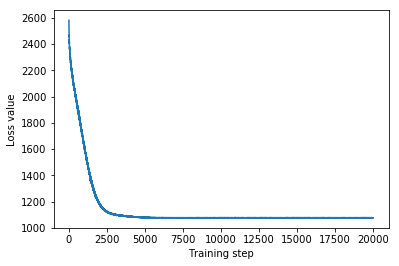

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
      target_model.unnormalized_log_prob,
      surrogate_posterior,
      optimizer=optimizer,
      num_steps=20000,
      sample_size=16,
      )
linop_loss = fit_vi()

linop_samples = surrogate_posterior.sample(1000)
linop_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*linop_samples)
    - surrogate_posterior.log_prob(linop_samples))

print('`LinearOperator` surrogate posterior ELBO: {}'.format(linop_final_elbo))

plt.plot(linop_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

### Inverse Autoregressive Flow surrogate posterior

This example builds the surrogate posterior with an Inverse Autoregressive Flow (IAF), which can capture complex, nonlinear dependencies among the posterior components.

In [ ]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`, `event_unflatten`,
# and `reshape_bijector` are the same as in the `LinearOperator` surrogate
# posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         event_unflatten,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the prior components
         split] +          # Split the samples into components of the same size as the prior components
         iaf_bijectors     # Apply a flow model to the Tensor-valued standard Normal distribution
         ))

Train the IAF surrogate posterior.

IAF surrogate posterior ELBO: -1078.9591064453125


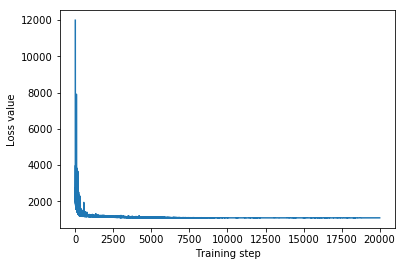

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=20000,
    sample_size=4
    )
iaf_loss = fit_vi()

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

### Baseline: Mean-field surrogate posterior

VI surrogate posteriors are often assumed to be mean-field (independent) Normal distributions, with trainable means and variances, that are constrained to the support of the prior with a bijective transformation. We define a mean-field surrogate posterior for comparison with the two more expressive surrogate posteriors.

Mean-field surrogate posterior ELBO: -1082.6866455078125


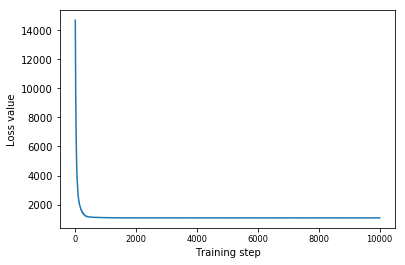

In [ ]:
mean_field_surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=target_model.event_shape,
    bijector=target_model.experimental_default_event_space_bijector())

optimizer=tf.optimizers.Adam(learning_rate=1e-2)
@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    mean_field_surrogate_posterior,
    optimizer=optimizer,
    num_steps=10000,
    sample_size=16)
mean_field_loss = fit_vi()

mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mean_field_samples)
    - mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))

plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

### Ground truth: Hamiltonian Monte Carlo (HMC)

We use HMC to generate "ground truth" samples from the true posterior.

In [ ]:
num_chains = 32
num_leapfrog_steps = 3
step_size = 0.4
num_steps=20000

flat_event_shape = tf.nest.flatten(target_model.event_shape)
enum_components = list(range(len(flat_event_shape)))
bijector = tfb.Restructure(
    enum_components,
    tf.nest.pack_sequence_as(target_model.event_shape, enum_components))(
        target_model.experimental_default_event_space_bijector())

current_state = bijector(
    tf.nest.map_structure(
        lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32),
    target_model.event_shape))

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_model.unnormalized_log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=[tf.fill(s.shape, step_size) for s in current_state])

hmc = tfp.mcmc.TransformedTransitionKernel(
    hmc, bijector)
hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    hmc,
    num_adaptation_steps=int(num_steps // 2 * 0.8),
    target_accept_prob=0.9)

chain, is_accepted = tf.function(
    lambda current_state: tfp.mcmc.sample_chain(
        current_state=current_state,
        kernel=hmc,
        num_results=num_steps // 2,
        num_burnin_steps=num_steps // 2,
        trace_fn=lambda _, pkr:
        (pkr.inner_results.inner_results.is_accepted),
        ),
    autograph=False,
    jit_compile=True)(current_state)

accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(
    lambda c: tfp.mcmc.effective_sample_size(
        c,
        cross_chain_dims=1,
        filter_beyond_positive_pairs=True),
    chain)

r_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = tf.nest.pack_sequence_as(target_model.event_shape, chain)

print('Acceptance rate is {}'.format(accept_rate))

Acceptance rate is 0.8871374726295471


Plot sample traces to sanity-check HMC results (showing the `county_effect` for just one of the 85 counties.)

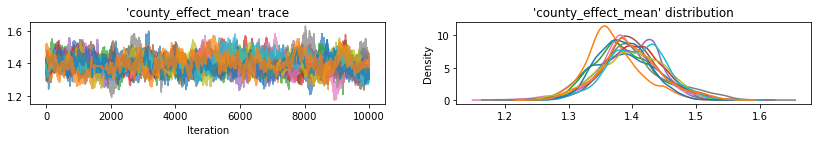

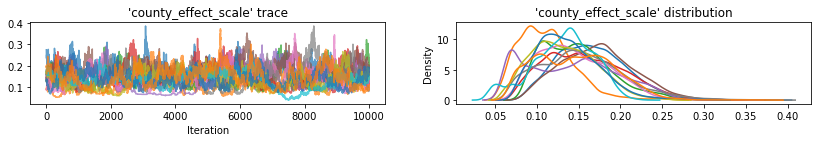

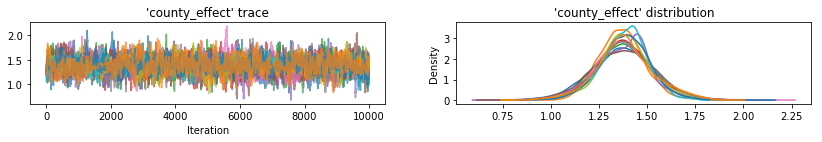

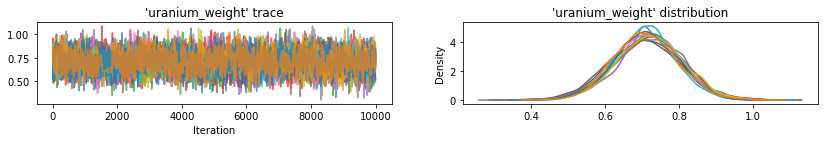

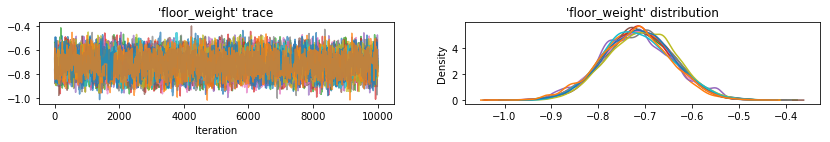

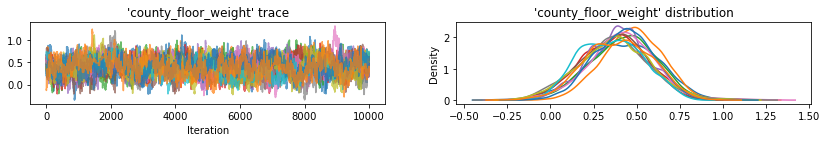

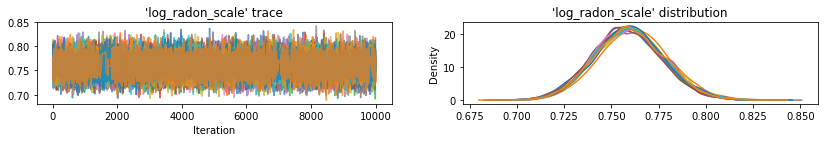

In [ ]:
weight_names = ['uranium_weight', 'floor_weight', 'county_floor_weight']

def plot_traces(var_name, samples, num_chains=12):
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    s = samples[:, chain]
    axes[0].plot(samples[:, chain].numpy(), alpha=0.7)
    sns.kdeplot(s.numpy(), ax=axes[1], shade=False)
    axes[0].title.set_text("'{}' trace".format(var_name))
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
  plt.show()

county = 5
for var, var_samples in hmc_samples._asdict().items():
  if var == 'county_effect':
    plot_traces(var, var_samples[:, :, county])
  elif var == 'weight':
    for i in range(3):
      plot_traces(weight_names[i], var_samples[:, :, i])
  else:
    plot_traces(var, var_samples)


## Comparison of results


In [ ]:
#@title Plotting functions
county = 5

results = {
    'hmc': hmc_samples._asdict(),
    'linop': linop_samples._asdict(),
    'iaf': iaf_samples._asdict(),
    'mean_field': mean_field_samples._asdict()
}

labels = {
    'hmc': 'HMC',
    'linop': 'Linear Operator',
    'iaf': 'IAF',
    'mean_field': 'Mean Field'}

plot_results = collections.defaultdict(dict)
for var in results['hmc'].keys():
  if var == 'county_effect':
    for posterior in results.keys():
      plot_results[var][posterior] = results[
        posterior][var][..., county].numpy()
  elif var == 'weight':
    for i in range(3):
      for posterior in results.keys():
        plot_results[
          weight_names[i]][posterior] = results[posterior][var][..., i].numpy()
  else:
    for posterior in results.keys():
      plot_results[var][posterior] = results[posterior][var].numpy()

plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize': 'medium'})
def plot_loss_and_elbo():
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].scatter([0, 1, 2],
                  [linop_final_elbo.numpy(),
                  iaf_final_elbo.numpy(),
                  mean_field_final_elbo.numpy()])
  axes[0].set_xticks(ticks=[0, 1, 2])
  axes[0].set_xticklabels(labels=[
    'Linear Operator', 'IAF', 'Mean Field'])
  axes[0].title.set_text('Evidence Lower Bound (ELBO)')

  axes[1].plot(linop_loss, label='Linear Operator')
  axes[1].plot(iaf_loss, label='IAF')
  axes[1].plot(mean_field_loss, label='Mean Field')
  axes[1].set_ylim([1000, 4000])
  axes[1].set_xlabel('Training step')
  axes[1].set_ylabel('Loss (negative ELBO)')
  axes[1].title.set_text('Loss')
  plt.legend()
  plt.show()

plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize': 'small'})
def plot_kdes(num_chains=8):
  fig, axes = plt.subplots(4, 2, figsize=(16, 12))
  for i, (var, var_results) in enumerate(plot_results.items()):
    ax = axes[i % 4, i // 4]
    for posterior, posterior_results in var_results.items():
      if posterior == 'hmc':
        label = labels[posterior]
        for chain in range(num_chains):
          sns.kdeplot(
              posterior_results[:, chain],
              ax=ax, shade=False, color='k', linestyle=':', label=label)
          label=None
      else:
        sns.kdeplot(
            posterior_results, ax=ax, shade=False, label=labels[posterior])
        ax.title.set_text('{}'.format(var))
    ax.legend()
  axes[3, 1].set_axis_off()

def plot_boxplot(num_chains=8):
  fig, axes = plt.subplots(4, 2, figsize=(16, 16))
  for i, (var, var_results) in enumerate(plot_results.items()):
    ax = axes[i % 4, i // 4]
    all_posterior_results = []
    posterior_names = []
    for posterior, posterior_results in var_results.items():
      if posterior == 'hmc':
        posterior_results = posterior_results[:, :num_chains].flatten()
      all_posterior_results.append(posterior_results)
      posterior_names.append(posterior)

    ax.boxplot(all_posterior_results)
    ax.title.set_text('{}'.format(var))
    ax.set_xticklabels(posterior_names)
  axes[3, 1].set_axis_off()

### Evidence Lower Bound (ELBO)

IAF, by far the largest and most flexible surrogate posterior, converges to the highest Evidence Lower Bound (ELBO). The mean-field surrogate posterior, which assumes independence among model parameters, converges quickly but to a lower ELBO. The constrained multivariate Normal, with covariance structure induced by the blockwise `LinearOperator`. 

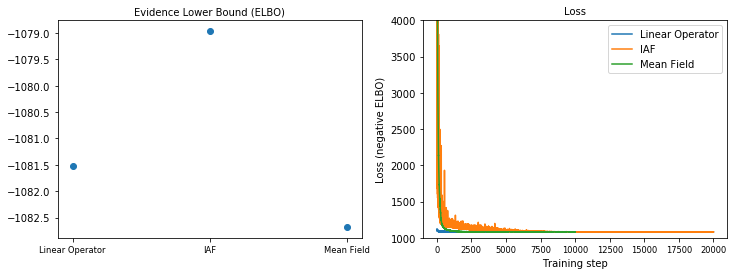

In [ ]:
plot_loss_and_elbo()

### Posterior samples

Samples from each surrogate posterior, compared with HMC ground truth samples.

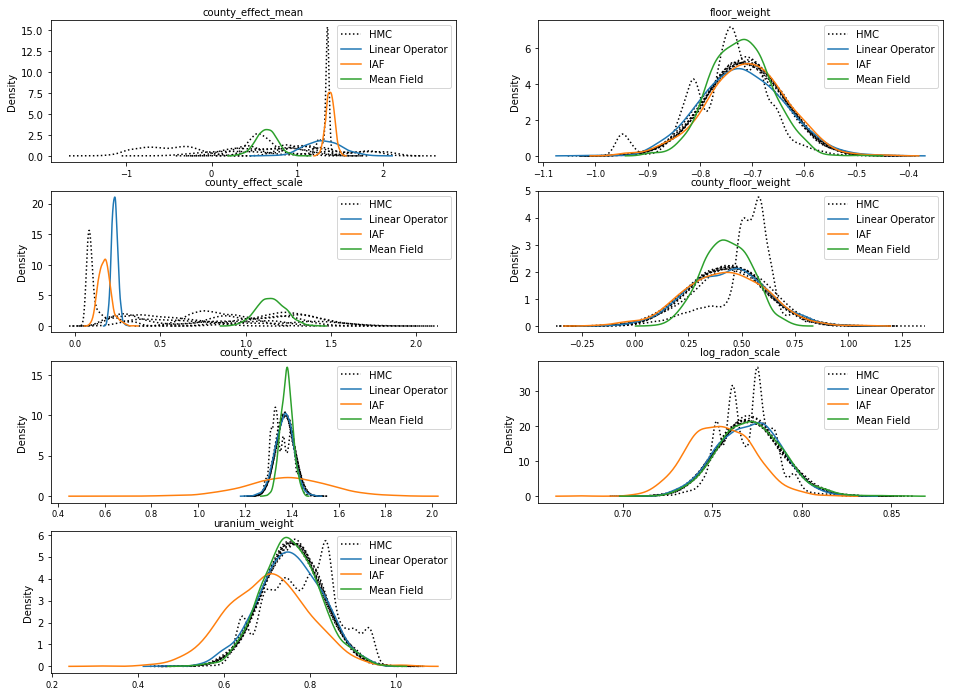

In [ ]:
plot_kdes()

Mean and standard deviation of posterior samples. Mean field samples tend to be underdispersed, compared with the more expressive surrogate posteriors.

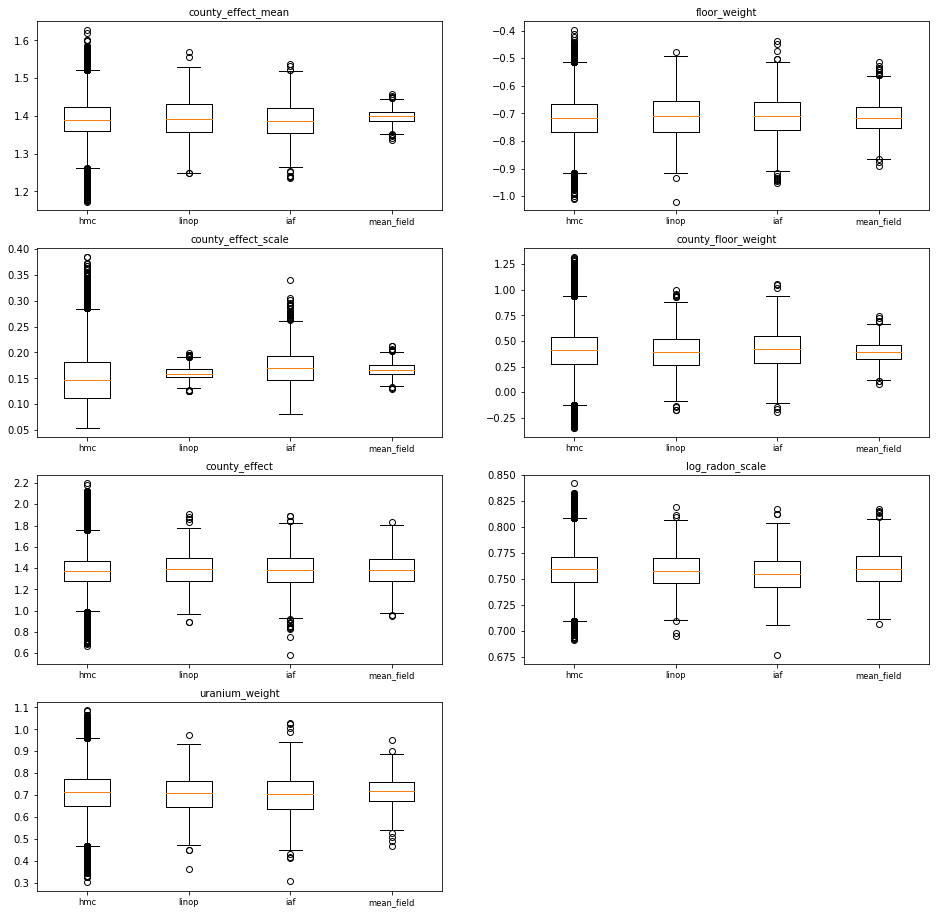

In [ ]:
plot_boxplot()